# Laboratory 4: CNN in NLP

Authors:
* Kuntur Muenala
* Diego Villacreses

## Import libraries

In [30]:
import torch
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from wordcloud import WordCloud

import spacy

import matplotlib.pyplot as plt

import os

os.chdir("/home/dvillacreses/nlp")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print(device)

There are 2 GPU(s) available.
Device name: NVIDIA A100 80GB PCIe
cuda


In [ ]:
def predict_next_word(model, input_sequence, ttoi, itot, top_k=1, device='cpu'):
    model.eval()  # Set the model to evaluation mode

    # Convert input_sequence (list of words) to tensor of indices
    input_indices = torch.tensor([ttoi[word] for word in input_sequence], dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Move input tensor to the correct device
    input_indices = input_indices.to(device)

    # Forward pass through the model
    with torch.no_grad():
        logits = model(input_indices)

    # Convert logits to probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the top_k predictions (default is top 1)
    top_probabilities, top_indices = torch.topk(probabilities, top_k, dim=-1)

    # Convert top_indices to words
    predicted_words = [itot[idx.item()] for idx in top_indices[0]]

    return predicted_words


## Data Loading

In [33]:
text = open('gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()
#text = open('cap1.txt', 'r').read().lower()

## Data preprocessing

In [34]:
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')
nlp = spacy.load('es_core_news_sm') # lemmatization

In [35]:
def split_tokens(text, tokenizer_type = 'full'):
    if tokenizer_type=='full':
        tokens = tokenizer.tokenize(text)
    if tokenizer_type=='stop_words':
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if w not in sw] # delete stopwords
    if tokenizer_type=='steam':
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if w not in sw] # delete stopwords
        tokens = [ss.stem(w) for w in tokens] # steam words
    if tokenizer_type=='lemma':
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if w not in sw] # delete stopwords
        tokens = [ss.stem(w) for w in tokens] # steam words
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc] # lemmatization
    if tokenizer_type=='only_lemma':
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if w not in sw] # delete stopwords
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc] # lemmatization
    return tokens

In [36]:
tokens_full = split_tokens(text,'full')
tokens_stop_words = split_tokens(text,'stop_words')
tokens_steam = split_tokens(text,'steam')
tokens_lemma = split_tokens(text,'lemma')
tokens_only_lemma = split_tokens(text,'only_lemma')

In [37]:
counts_full = Counter(tokens_full)
counts_stop_words = Counter(tokens_stop_words)
counts_steam = Counter(tokens_steam)
counts_lemma = Counter(tokens_lemma)
counts_only_lemma = Counter(tokens_only_lemma)

## EDA

In [38]:
print(f"{len(np.unique(tokens_full))=}")
print(f"{len(np.unique(tokens_stop_words))=}")
print(f"{len(np.unique(tokens_steam))=}")
print(f"{len(np.unique(tokens_lemma))=}")
print(f"{len(np.unique(tokens_only_lemma))=}")

len(np.unique(tokens_full))=15866
len(np.unique(tokens_stop_words))=15672
len(np.unique(tokens_steam))=7554
len(np.unique(tokens_lemma))=7764
len(np.unique(tokens_only_lemma))=11586


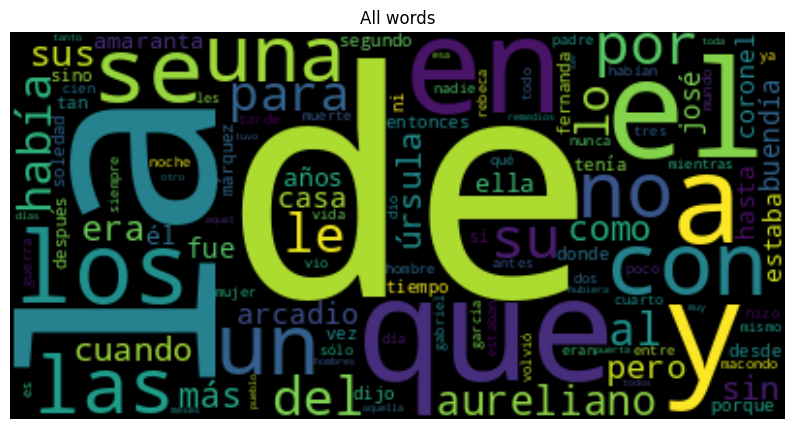

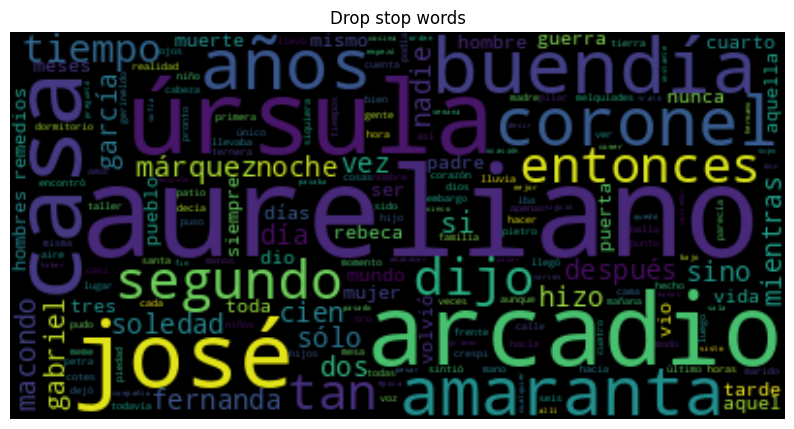

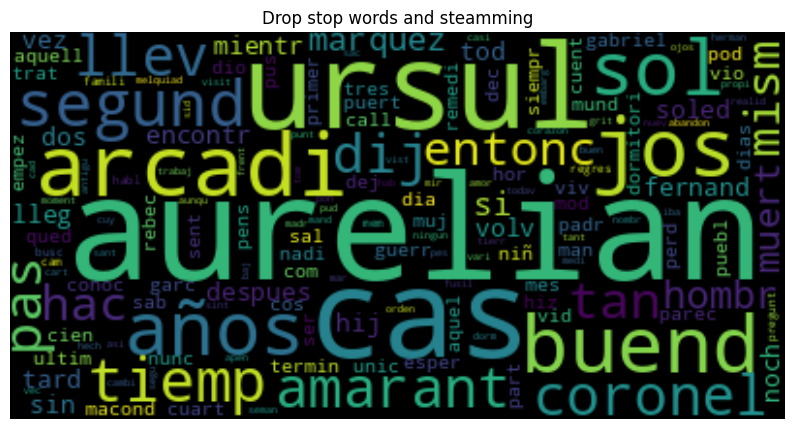

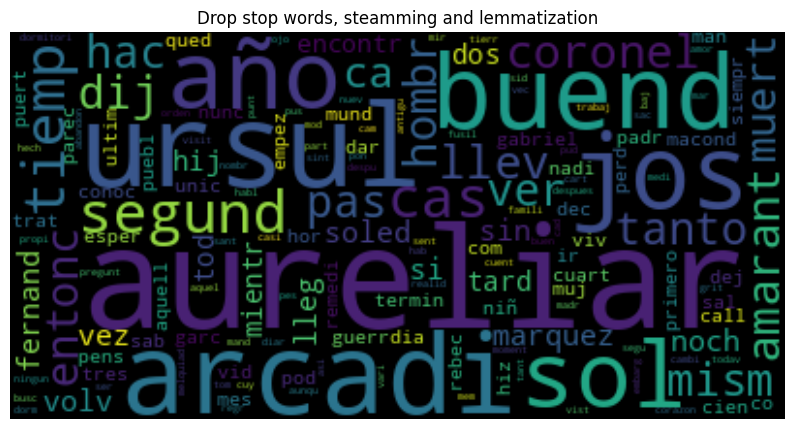

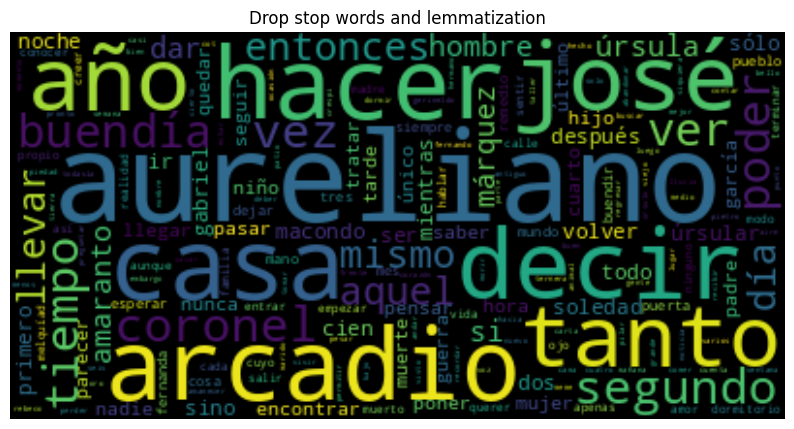

In [40]:
d = {
    "All words":counts_full,
    "Drop stop words":counts_stop_words,
    "Drop stop words and steamming":counts_steam,
    "Drop stop words, steamming and lemmatization":counts_lemma,
    "Drop stop words and lemmatization":counts_only_lemma
    }

for key, item in d.items():
    wcloud = WordCloud().generate_from_frequencies(item)

    plt.figure(figsize=(10,8))
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(key)
    plt.show()
    print()

In [41]:
d = {
    "All words":[counts_full,tokens_full],
    "Drop stop words":[counts_stop_words,tokens_stop_words],
    "Drop stop words and steamming":[counts_steam,tokens_steam],
    "Drop stop words, steamming and lemmatization":[counts_lemma,tokens_lemma],
    "Drop stop words and lemmatization":[counts_only_lemma,tokens_only_lemma]
    }

for key, item in d.items():
    counts_more_than_1 = {k:v for k,v in item[0].items() if v > 1}
    vocab = list(counts_more_than_1.keys())
    itot = dict(enumerate(vocab))
    ttoi = {v:k for k,v in itot.items()}
    tokens_more_than_1 = [w for w in item[1] if w in vocab]
    print(key, ", total tokens with more than 1:", len(np.unique(tokens_more_than_1)))

All words , total tokens with more than 1: 7577
Drop stop words , total tokens with more than 1: 7406
Drop stop words and steamming , total tokens with more than 1: 4855
Drop stop words, steamming and lemmatization , total tokens with more than 1: 4894
Drop stop words and lemmatization , total tokens with more than 1: 6084


## Let's prepare the window for word2vec

In [42]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i+j] for j in range(-win, win+1,1)
                  if (i+j >= 0) & (i+j < len(tokens)) & (j != 0)]
       # print(window)
        output += [(target, ttoi[j]) for j in window]
    return output

class text_dataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x =  F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y

In [43]:
data_windowed = window(tokens_more_than_1, win=4)

In [44]:
dataset = text_dataset(data_windowed, len(vocab))

In [45]:
print(f"{dataset.vocab_size=}")
print(f"{len(dataset.data)=}")


dataset.vocab_size=6084
len(dataset.data)=518004


## Building the network

In [140]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input.to(torch.int64))
        logits = self.expand(hidden)
        return logits

In [141]:
model = Word2Vec(len(vocab), 100)
model.to(device)
model = model.to(device)

In [142]:
model

Word2Vec(
  (embed): Embedding(6084, 100)
  (expand): Linear(in_features=100, out_features=6084, bias=False)
)

In [143]:
LR = 3e-3
EPOCHS = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
running_loss = []
running_acc = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    train_accuracy = 0
    total_samples = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)
        context = context.to(torch.float).to(device)
        center = center.to(torch.float).to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(logits.data, 1)
        train_accuracy += (predicted==torch.max(center, 1)[1]).sum().item()
        total_samples += center.size(0)
    train_accuracy /= total_samples
    epoch_loss /= len(dataloader)
    print(f"Epoch number: {epoch+1}/{EPOCHS}. Train Loss: {epoch_loss}, Train Accuracy: {train_accuracy}")
    running_loss.append(epoch_loss)
    running_acc.append(train_accuracy)

Epoch number: 1/20. Train Loss: 7.921905386497982, Train Accuracy: 0.014189079621006788
Epoch number: 2/20. Train Loss: 7.371493276914668, Train Accuracy: 0.01764272090563007
Epoch number: 3/20. Train Loss: 7.0558687832316025, Train Accuracy: 0.01687631755739338
Epoch number: 4/20. Train Loss: 6.885982920276933, Train Accuracy: 0.015953544760272123
Epoch number: 5/20. Train Loss: 6.797130150355496, Train Accuracy: 0.01555972540752581
Epoch number: 6/20. Train Loss: 6.7442163990431725, Train Accuracy: 0.015675554628921784
Epoch number: 7/20. Train Loss: 6.709013292457782, Train Accuracy: 0.016021111806086438
Epoch number: 8/20. Train Loss: 6.684751020409839, Train Accuracy: 0.01635315557408823
Epoch number: 9/20. Train Loss: 6.668023750167556, Train Accuracy: 0.016407209210739685
Epoch number: 10/20. Train Loss: 6.653693139656167, Train Accuracy: 0.016627284731392036
Epoch number: 11/20. Train Loss: 6.644658494472857, Train Accuracy: 0.016663963984834093
Epoch number: 12/20. Train Loss:

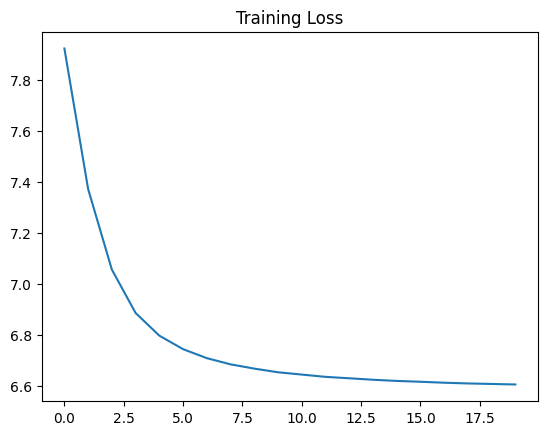

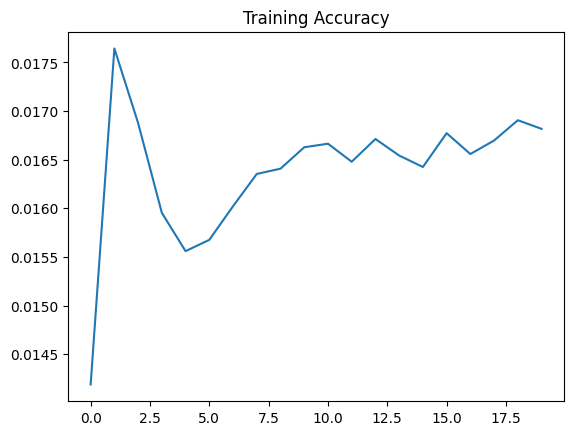

In [144]:
plt.plot(running_loss)
plt.title("Training Loss")
plt.show()
print()
plt.plot(running_acc)
plt.title("Training Accuracy")
plt.show()

In [145]:
intersting_words = ['buendia','niño', 'pasado','artificio',
                    'color','posibilidad', 'mujer','oro']

for word in intersting_words:
  max_n_pred = 10
  full_pred = word
  for i in range(max_n_pred):
      word2 = predict_next_word(model, [word], ttoi, itot, top_k=1, device=device)[0]
      full_pred = full_pred + ' ' + word2
      word = word2
  print(full_pred)

buendia aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
niño niño niño niño niño niño niño niño niño niño niño
pasado quedar quedar quedar quedar quedar quedar quedar quedar quedar quedar
artificio artificio artificio artificio artificio artificio artificio artificio artificio artificio artificio
color color color color color color color color color color color
posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad posibilidad
mujer mujer mujer mujer mujer mujer mujer mujer mujer mujer mujer
oro pescadito oro pescadito oro pescadito oro pescadito oro pescadito oro


## CNN

In [90]:
class Word2Vec_CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_filters, filter_sizes):
        super(Word2Vec_CNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)

        # Convolutional layers with padding
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_size,
                      out_channels=num_filters,
                      kernel_size=fs,
                      padding=fs // 2)  # Adding padding to ensure the output size matches input size
            for fs in filter_sizes
        ])

        # Fully connected layer to map pooled features to the vocabulary
        self.fc = nn.Linear(num_filters * len(filter_sizes), vocab_size, bias=False)

    def forward(self, input):
        # Embedding layer: (batch_size, seq_len, embedding_size)
        embedded = self.embed(input.to(torch.int64))

        # Check if the embedded tensor has 2 dimensions, add a dimension if necessary
        if embedded.dim() == 2:  # When input has only a single token (seq_len = 1)
            embedded = embedded.unsqueeze(1)  # Add a sequence length dimension

        # Reshape to (batch_size, embedding_size, seq_len) for Conv1d
        embedded = embedded.permute(0, 2, 1)

        # Apply convolution + ReLU + Max Pooling over each filter size
        conv_outputs = [F.relu(conv(embedded)) for conv in self.convs]

        # Apply global max pooling over the time dimension (seq_len)
        pooled_outputs = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conv_outputs]

        # Concatenate pooled outputs from all filters
        concat_output = torch.cat(pooled_outputs, dim=1)

        # Final fully connected layer
        logits = self.fc(concat_output)

        return logits


In [91]:
vocab_size = len(vocab)
embedding_size = 200
num_filters = 1000  # Number of filters per filter size
filter_sizes = [2, 3, 4, 5]   # Different filter sizes (e.g., trigram, 4-gram, 5-gram)

model = Word2Vec_CNN(vocab_size, embedding_size, num_filters, filter_sizes)
model.to(device)
model = model.to(device)
model

Word2Vec_CNN(
  (embed): Embedding(6084, 200)
  (convs): ModuleList(
    (0): Conv1d(200, 1000, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(200, 1000, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(200, 1000, kernel_size=(4,), stride=(1,), padding=(2,))
    (3): Conv1d(200, 1000, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (fc): Linear(in_features=4000, out_features=6084, bias=False)
)

In [92]:
len(dataset.data)

518004

In [93]:
LR = 1e-3
EPOCHS = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
running_loss = []
running_acc = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    train_accuracy = 0
    total_samples = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)
        context = context.to(torch.float).to(device)
        center = center.to(torch.float).to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(logits.data, 1)
        train_accuracy += (predicted==torch.max(center, 1)[1]).sum().item()
        total_samples += center.size(0)
    train_accuracy /= total_samples
    epoch_loss /= len(dataloader)
    print(f"Epoch number{epoch+1}/{EPOCHS}. Train Loss: {epoch_loss}, Train Accuracy: {train_accuracy}")
    running_loss.append(epoch_loss)
    running_acc.append(train_accuracy)

Epoch number1/20. Train Loss: 7.971791559895204, Train Accuracy: 0.01577400946710836
Epoch number2/20. Train Loss: 7.883347702226669, Train Accuracy: 0.01563694488845646
Epoch number3/20. Train Loss: 7.629187633468688, Train Accuracy: 0.016893691940602775
Epoch number4/20. Train Loss: 7.46510118203367, Train Accuracy: 0.01771607941251419
Epoch number5/20. Train Loss: 7.363701201086136, Train Accuracy: 0.018328043798889585
Epoch number6/20. Train Loss: 7.300010181633902, Train Accuracy: 0.01844773399433209
Epoch number7/20. Train Loss: 7.258678617081525, Train Accuracy: 0.018768194840194284
Epoch number8/20. Train Loss: 7.230192642197775, Train Accuracy: 0.018992131334893168
Epoch number9/20. Train Loss: 7.208267782480887, Train Accuracy: 0.019071281302847083
Epoch number10/20. Train Loss: 7.190268510119073, Train Accuracy: 0.019069350815823817
Epoch number11/20. Train Loss: 7.174825486766871, Train Accuracy: 0.019233442212801447
Epoch number12/20. Train Loss: 7.161809876314469, Train A

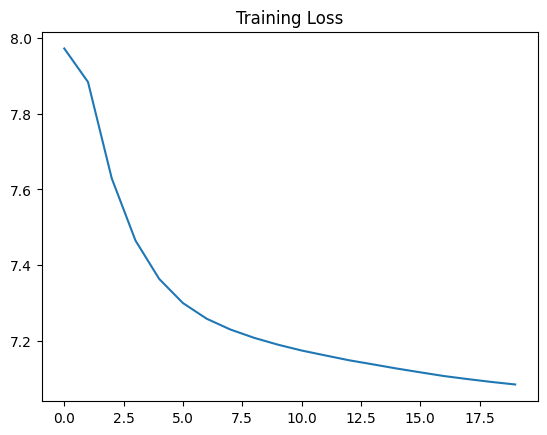

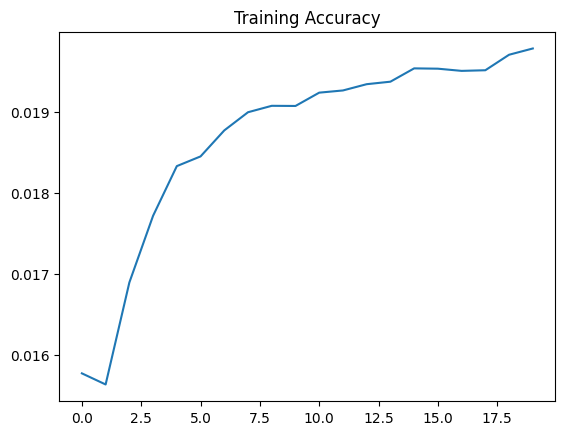

In [94]:
plt.plot(running_loss)
plt.title("Training Loss")
plt.show()
print()
plt.plot(running_acc)
plt.title("Training Accuracy")
plt.show()

In [139]:
input_sequence = ['segundo']
predicted_words = predict_next_word(model, input_sequence, ttoi, itot, top_k=1, device=device)

print(f"Predicted next word: {predicted_words[0]}")

Predicted next word: aureliano


In [127]:
intersting_words = ['buendia','niño', 'pasado','artificio',
                    'color','posibilidad', 'mujer','oro']

for word in intersting_words:
  max_n_pred = 10
  full_pred = word
  for i in range(max_n_pred):
      word2 = predict_next_word(model, [word], ttoi, itot, top_k=1, device=device)[0]
      full_pred = full_pred + ' ' + word2
      word = word2
  print(full_pred)

buendia aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
niño aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
pasado aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
artificio aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
color aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
posibilidad aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
mujer aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo
oro aureliano segundo aureliano segundo aureliano segundo aureliano segundo aureliano segundo


In [146]:
0.01977783955336252/0.01764272090563007

1.1210198052303315

## Discusion

After a simple EDA, subjectively, we choose to drop stop words plus lemmatization from `spacy`, since, that preprocessing seems the most parsimonious from a visual inspection of the word cloud.

After our preprocessing, we apply a windowed dataset with a window value of four using the full book of 100 Years of Solitude by G. G. Márquez. The usage of the full book adds important computational complexity to our computations.

We compute two Neural Network Models: i) a simple fully connected network, ii) Convolutional Neural Network (CNN). For both models, we use Adam optimizer with 20 epochs, 64 elements per batch. The first model has one hidden layer with 100 neurons and an embedding size of 100. Hyperparameter Optimization (HPO) is not performed on this model. The simple model shows a training accuracy of 0.0176. Although simple, the model takes 10 minutes of training in a specialized server with A100 Nvidia GPU. For the second model an extensive HPO was performed, this was a time-consuming task since each iteration took at least 20 minutes to compute. We propose as best architecture for our CNN 4 hidden layers, each with 1000 filters, and an embedding size of 200, stride, and padding of 1. Kernel size could be interpreted as n-gram modeling, since the kernel size told the model how many words should be taken into context for its training, we choose 2, 3, 4, and 5 for each hidden layer. After this extensive HPO, we got a 0.0197 accuracy, a small improvement of only 12 percentage points over an already very small accuracy. As can be seen from the model predictions, both models create poor sentences from important words.

As a general suggestion, we consider that general guides and consideration for HPO in this kind NLP should be studied, also, Bayesian HPO should be considered.